In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load processed data
X_train = pd.read_csv('../data/processed/X_train_scaled.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')['price']
X_test = pd.read_csv('../data/processed/X_test_scaled.csv')

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Split for validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)

print(f"\nTrain: {X_tr.shape}")
print(f"Validation: {X_val.shape}")


X_train shape: (16209, 35)
y_train shape: (16209,)
X_test shape: (5404, 35)

Train: (13777, 35)
Validation: (2432, 35)


In [3]:
print("=" * 60)
print("BASELINE MODEL: XGBoost (Tabular Data Only)")
print("=" * 60)

# XGBoost model with early_stopping_rounds in constructor
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50  # Moved here
)

print("\n📊 Training XGBoost...")
xgb_model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Predictions
y_train_pred = xgb_model.predict(X_tr)
y_val_pred = xgb_model.predict(X_val)

# Evaluation metrics
def evaluate(y_true, y_pred, dataset_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n{dataset_name} Metrics:")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  MAE: ${mae:,.2f}")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

train_metrics = evaluate(y_tr, y_train_pred, "Training")
val_metrics = evaluate(y_val, y_val_pred, "Validation")

print(f"\n✅ Baseline XGBoost R² Score: {val_metrics['R2']:.4f}")
print(f"✅ Baseline XGBoost RMSE: ${val_metrics['RMSE']:,.2f}")


BASELINE MODEL: XGBoost (Tabular Data Only)

📊 Training XGBoost...

Training Metrics:
  RMSE: $42,388.33
  MAE: $30,865.26
  R² Score: 0.9863
  MAPE: 7.20%

Validation Metrics:
  RMSE: $117,540.69
  MAE: $66,187.65
  R² Score: 0.8849
  MAPE: 12.11%

✅ Baseline XGBoost R² Score: 0.8849
✅ Baseline XGBoost RMSE: $117,540.69


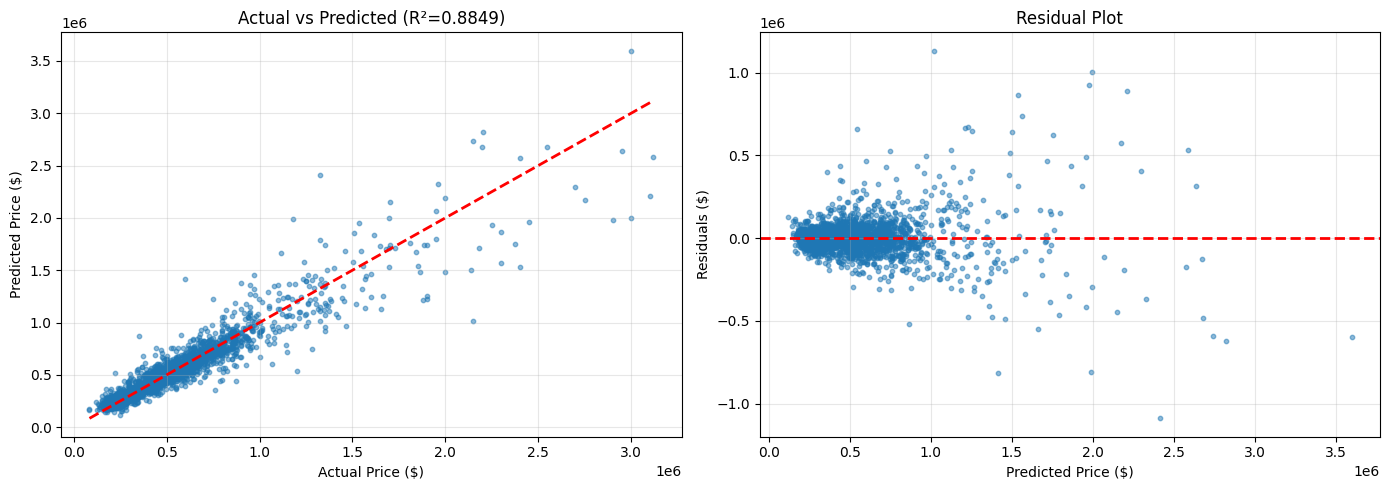


📊 Top 15 Most Important Features:
                   feature  importance
31              high_grade    0.509550
8                    grade    0.147773
22            luxury_score    0.100031
5               waterfront    0.046546
2              sqft_living    0.045194
34      dist_from_downtown    0.022960
13                     lat    0.021006
33        location_cluster    0.015530
9               sqft_above    0.012866
15           sqft_living15    0.009255
24  years_since_renovation    0.007508
1                bathrooms    0.006686
10           sqft_basement    0.004711
12            yr_renovated    0.004620
6                     view    0.003934


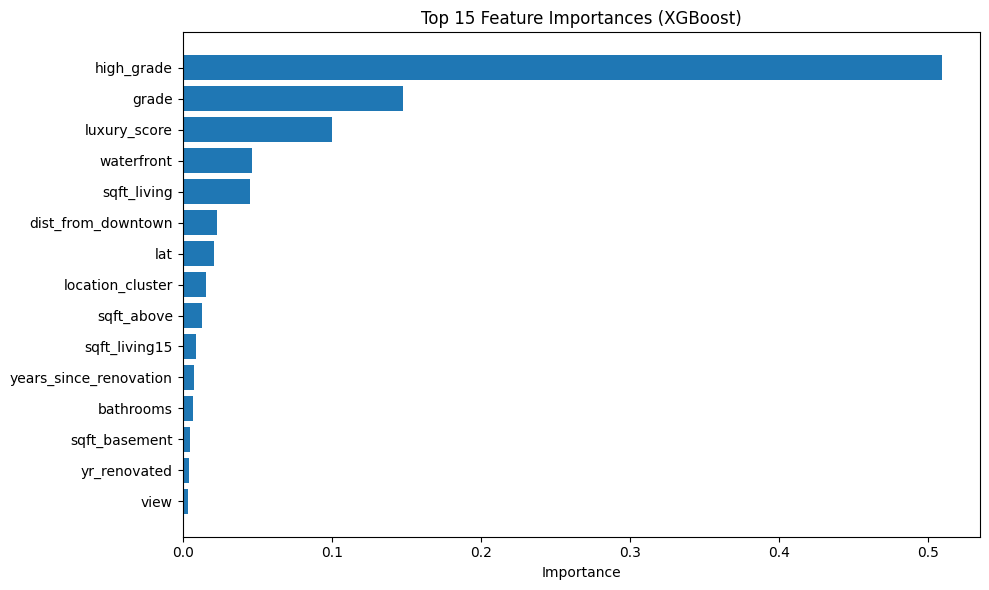

In [4]:
# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: Actual vs Predicted
axes[0].scatter(y_val, y_val_pred, alpha=0.5, s=10)
axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price ($)')
axes[0].set_ylabel('Predicted Price ($)')
axes[0].set_title(f'Actual vs Predicted (R²={val_metrics["R2"]:.4f})')
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = y_val - y_val_pred
axes[1].scatter(y_val_pred, residuals, alpha=0.5, s=10)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price ($)')
axes[1].set_ylabel('Residuals ($)')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Top 15 Most Important Features:")
print(feature_importance.head(15))

# Plot top 15 features
plt.figure(figsize=(10, 6))
top_15 = feature_importance.head(15)
plt.barh(range(len(top_15)), top_15['importance'])
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [7]:
import pickle
import os

# Create directories if they don't exist
os.makedirs('../outputs/models', exist_ok=True)
os.makedirs('../outputs/predictions', exist_ok=True)

# Save the model
print("💾 Saving baseline model...")
with open('../outputs/models/xgboost_baseline.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

# Generate predictions on test set
print("\n🔮 Generating test predictions...")
test_predictions = xgb_model.predict(X_test)

# Load test IDs
test_df = pd.read_excel('../data/raw/test.xlsx')

# Create submission file
submission = pd.DataFrame({
    'id': test_df['id'],
    'predicted_price': test_predictions
})

submission.to_csv('../outputs/predictions/baseline_submission.csv', index=False)

print(f"✅ Baseline model saved!")
print(f"✅ Test predictions saved to: outputs/predictions/baseline_submission.csv")
print(f"\nPrediction statistics:")
print(f"  Min: ${test_predictions.min():,.2f}")
print(f"  Max: ${test_predictions.max():,.2f}")
print(f"  Mean: ${test_predictions.mean():,.2f}")
print(f"  Median: ${np.median(test_predictions):,.2f}")



💾 Saving baseline model...

🔮 Generating test predictions...
✅ Baseline model saved!
✅ Test predictions saved to: outputs/predictions/baseline_submission.csv

Prediction statistics:
  Min: $106,460.05
  Max: $5,251,428.00
  Mean: $544,397.81
  Median: $455,444.50
